# Cong Workbook


### Import Libraries
Let's first import some stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install mysql-connector-python

In [3]:
import mysql.connector

In [4]:
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

### Loading SQL Queries

In [5]:
tn = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.tn_movie_budgets""", con))

In [6]:
#Change data types
tn['domestic_gross'] = tn['domestic_gross'].str.replace('$','')  
tn['domestic_gross'] = tn['domestic_gross'].str.replace(',','')
tn['domestic_gross'] = tn['domestic_gross'].astype(float)
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace('$','')
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace(',','')
tn['worldwide_gross'] =tn['worldwide_gross'].astype(float) 
tn['production_budget'] =tn['production_budget'].str.replace('$','')
tn['production_budget'] =tn['production_budget'].str.replace(',','')
tn['production_budget'] =tn['production_budget'].astype(float) 
tn['release_date'] = pd.to_datetime(tn['release_date'])

In [7]:
bom = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.bom_movie_gross""", con))

In [8]:
tmd = pd.DataFrame(pd.read_sql_query("""
SELECT
	title,
    vote_average,
    popularity,
    release_date
FROM movies.tmdb_movies""", con))

In [9]:
tmd['release_date'] = pd.to_datetime(tmd['release_date'])

In [10]:
tmd = tmd.drop_duplicates(subset='title',keep=False)

In [11]:
imdb_title_basics = pd.DataFrame(pd.read_sql_query("""
SELECT 
	primary_title,
    genres,
    start_year
FROM movies.imdb_title_basics""", con))

In [12]:
imdb_title_basics['title_new'] = imdb_title_basics['primary_title'].apply(lambda x: x.replace(' ',''))
imdb_title_basics['title_new'] = imdb_title_basics['title_new'].apply(lambda x: x.lower())
imdb_title_basics['title_new_year'] = imdb_title_basics['title_new'] + imdb_title_basics['start_year'].astype(str)

In [302]:
# SELECT *
# FROM movies.imdb_title_basics
# JOIN movies.imdb_title_ratings USING (tconst)
#to compare ImDB genre to ratings 

In [303]:
# SELECT
# 	nconst,
#     tconst,
#     ordering,
#     category,
#     primary_title,
#     start_year,
#     genres,
#     primary_name,
#     averagerating,
#     numvotes
# FROM movies.imdb_title_principals
# JOIN movies.imdb_title_basics USING (tconst)
# JOIN movies.imdb_name_basics USING (nconst)
# JOIN movies.imdb_title_ratings USING (tconst)
# WHERE start_year >= 2015
#to show which actresses / actors / directors appeared in most highly rated movies since 2015

In [304]:
# tn = pd.DataFrame(pd.read_sql_query("""
# SELECT Count(*)
# 	tconst,
#     primary_title,
#     averagerating,
#     numvotes
# FROM movies.imdb_title_ratings
# JOIN movies.imdb_title_basics USING (tconst)""", con))
# to join with tbi to get ratings vs. box office success correlation

### Worldwide Gross by Genre and Season

In [13]:
# JOIN bom and tn
tb = tn.join(bom.set_index('title'),
             on='movie',
             how='outer',
             lsuffix='_tn',
             rsuffix='_bom')

In [14]:
# JOIN tb with tmd
tbt = tb.join(
        tmd.set_index('title'),
        on='movie',
        how='left',
        rsuffix='_tmd')

In [15]:
tbt['release_date'] = np.where(tbt['release_date'].isna(), tbt['release_date_tmd'], tbt['release_date']) 

In [16]:
tbt = tbt.drop(columns='release_date_tmd')

In [17]:
tbt['year'] = np.where(tbt['release_date'].isna(), tbt['year'], tbt['release_date'].dt.year)
tbt['movie_new'] = tbt['movie'].apply(lambda x: x.replace(' ',''))
tbt['movie_new'] = tbt['movie_new'].apply(lambda x: x.lower())
tbt['movie_new_year'] = tbt['movie_new'] + tbt['year'].astype(str)
tbt['movie_new_year'] = tbt['movie_new_year'].apply(lambda x: x.replace('.0','')) 

In [18]:
# JOIN tbt with imdb_title_basics
tbi = tbt.join(imdb_title_basics.set_index('title_new_year'),
        on='movie_new_year',
        how='left',
        rsuffix='_imdb')

In [19]:
tbi = tbi.drop_duplicates(subset = 'movie')

In [19]:
tbi['domestic_gross_tn'] = np.where(tbi['domestic_gross_tn'].isna(), tbi['domestic_gross_bom'], tbi['domestic_gross_tn']) 
tbi = tbi.drop(columns=['domestic_gross_bom','studio'])
tbi['release_month'] = tbi['release_date'].dt.month
tbi = tbi.rename(columns={'production_budget':'production_budget_$m','domestic_gross_tn':'domestic_gross_$m','worldwide_gross':'worldwide_gross_$m', 'foreign_gross':'foreign_gross_$m'})

In [20]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))

In [21]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].astype(float)
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].astype(float)
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].astype(float)
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].astype(float)

In [22]:
tbi['release_year'] = tbi['release_date'].dt.year
tbi['global_mom'] = tbi['worldwide_gross_$m'] / tbi['production_budget_$m']
tbi = tbi.round({'global_mom':2})

In [23]:
tbi['release_year'] = tbi['release_date'].dt.year
tbi['release_month'] = tbi['release_date'].dt.month

In [24]:
tbi['worldwide_gross_$m'] = np.where(tbi['worldwide_gross_$m'].isna(), tbi['domestic_gross_$m'] + tbi['foreign_gross_$m'], tbi['worldwide_gross_$m'])

In [25]:
tbi = tbi.drop(columns=['year','start_year','movie_new'])

In [70]:
tbi.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8012 entries, 0.0 to nan
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    5846 non-null   float64       
 1   release_date          6823 non-null   datetime64[ns]
 2   movie                 8012 non-null   object        
 3   production_budget_$m  5846 non-null   float64       
 4   domestic_gross_$m     7986 non-null   float64       
 5   worldwide_gross_$m    6783 non-null   float64       
 6   foreign_gross_$m      2072 non-null   float64       
 7   vote_average          2646 non-null   float64       
 8   popularity            2646 non-null   float64       
 9   movie_new_year        8012 non-null   object        
 10  primary_title         2565 non-null   object        
 11  genres                2565 non-null   object        
 12  title_new             2565 non-null   object        
 13  release_month  

In [211]:
tbi['movie_new_year']

0.0                                   avatar2009
1.0    piratesofthecaribbean:onstrangertides2011
2.0                              darkphoenix2019
3.0                     avengers:ageofultron2015
4.0              starwarsep.viii:thelastjedi2017
                         ...                    
NaN                                 thequake2018
NaN                 edwardii(2018re-release)2018
NaN                                  elpacto2018
NaN                                  theswan2018
NaN                          anactorprepares2018
Name: movie_new_year, Length: 8012, dtype: object

In [71]:
tbi_genre = pd.DataFrame(tbi.genres.str.split(',').tolist(), index=tbi.movie).stack()

In [77]:
tbi_genre =tbi_genre.reset_index([0, 'movie'])

In [90]:
tbi_genre

,movie,0
0,Pirates of the Caribbean: On Stranger Tides,"[Action, Adventure, Fantasy]"
1,Dark Phoenix,"[Action, Adventure, Sci-Fi]"
2,Avengers: Age of Ultron,"[Action, Adventure, Sci-Fi]"
3,Avengers: Infinity War,"[Action, Adventure, Sci-Fi]"
4,Justice League,"[Action, Adventure, Fantasy]"
...,...,...
2560,The Workshop,[Thriller]
2561,A Paris Education,[Drama]
2562,Souvenir,"[Drama, Music, Romance]"
2563,The Quake,"[Action, Drama, Thriller]"


In [95]:
tbi_genre = tbi_genre.join(tbi.set_index('movie'),on='movie')

In [99]:
tbi_genre = tbi_genre.rename(columns={0:'genre'})

In [101]:
tbi_genre = tbi_genre.explode('genre')

In [104]:
tbi_genre = tbi_genre.drop(columns='genres')

In [115]:
tbi_genre2 = tbi_genre.replace(tbi_genre.loc[tbi_genre['genre']==''],np.nan)

In [187]:
tbi_genre['release_month'] = tbi_genre['release_date'].dt.month

In [194]:
tbi['release_month'] = tbi['release_date'].dt.month

### Execution

In [106]:
import seaborn as sns

In [120]:
tbi_since1990 = tbi_genre.loc[tbi_genre['release_year'] > 1989]

In [134]:
tbi_since1990.groupby(['genre']).mean()

,id,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross_$m,vote_average,popularity,release_month,release_year,global_mom
genre,,,,,,,,,,
Action,50.443396,84.758454,93.064039,233.030837,162.567901,6.196172,13.661232,6.259259,2012.622776,inf
Adventure,48.524096,110.500000,121.219653,335.461111,234.856115,6.287075,15.628237,6.250000,2012.887255,inf
Animation,40.462963,95.685185,124.509804,347.090909,250.479167,6.286364,13.652340,6.625000,2013.769231,inf
Biography,56.133333,29.477273,41.489796,67.696429,42.833333,6.752727,9.119228,8.043478,2014.171053,inf
Comedy,49.869748,45.185345,66.978070,141.902622,99.025126,6.136187,9.924069,5.812500,2012.735211,inf
Crime,49.638095,37.846939,53.750000,107.392523,67.136986,6.321239,11.142712,5.977273,2012.578571,inf
Documentary,43.947368,15.629630,17.250000,34.750000,20.333333,6.949020,5.670412,7.166667,2012.925000,inf
Drama,54.035135,31.348624,36.744337,69.912698,50.331950,6.452174,8.951838,6.323699,2013.083929,inf
Family,59.065217,59.767442,103.411765,191.690476,86.629630,6.443750,10.342361,6.700000,2012.169811,3.115652


In [135]:
genre_vs_mom = tbi_since1990.groupby(['genre']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [126]:
genre_vs_mom

genre
Musical        6.380
Animation      3.000
Horror         2.765
Mystery        2.640
Biography      2.610
Comedy         2.570
Adventure      2.485
Sci-Fi         2.460
Romance        2.420
Thriller       2.280
Documentary    2.280
Action         2.250
Fantasy        2.210
Music          2.195
Drama          2.120
History        1.830
Crime          1.825
Sport          1.735
Family         1.720
Western        1.330
War            0.500
News             NaN
Name: global_mom, dtype: float64

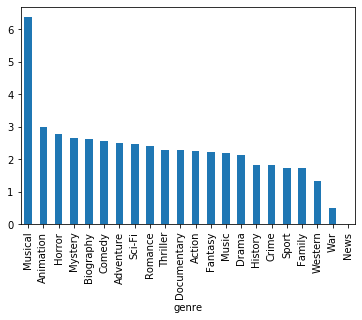

In [127]:
genre_vs_mom.plot.bar()

In [142]:
genre_vs_mom = genre_vs_mom.reset_index()

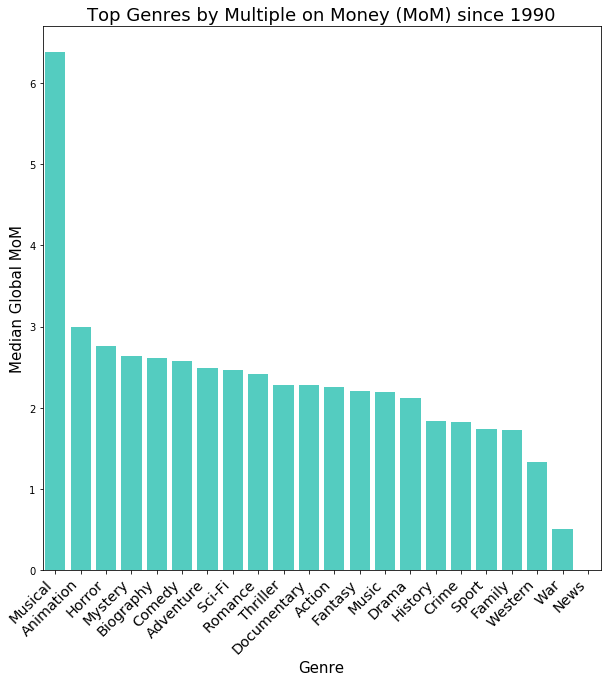

In [155]:
plt.figure(figsize=(10, 10))
chart = sns.barplot(x='genre',y='global_mom',data=genre_vs_mom, ci=None, color = 'turquoise')

# set labels
plt.xlabel("Genre", size=15)
plt.ylabel("Median Global MoM", size=15)
plt.title("Top Genres by Multiple on Money (MoM) since 1990", size=18)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

In [158]:
tbi_genre.groupby(['genre']).mean()

,id,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross_$m,vote_average,popularity,release_month,release_year,global_mom
genre,,,,,,,,,,
Action,50.309677,78.509719,93.035639,234.176360,158.715686,6.185185,14.891032,6.117647,2011.930314,inf
Adventure,48.319444,105.664850,126.727960,339.589074,228.347305,6.335542,17.046611,6.410714,2012.028846,inf
Animation,43.961165,99.179245,134.008333,354.081967,236.214953,6.394792,14.281481,6.000000,2013.769231,inf
Biography,51.427536,27.693548,37.273885,72.256098,48.772358,6.730488,9.839043,7.672414,2012.538462,inf
Comedy,49.758221,43.654150,63.473022,137.061789,89.894628,6.180986,10.505549,6.196653,2012.574230,inf
Crime,48.279835,33.299145,41.472340,84.033582,45.096447,6.269202,11.495304,6.068966,2012.013986,inf
Documentary,41.538462,25.394366,33.337500,66.178571,17.844444,6.843846,6.159398,6.775000,2012.925000,inf
Drama,51.061635,29.303324,36.763708,75.916476,50.416399,6.454218,9.513038,6.601023,2012.328070,inf
Family,57.169811,64.226415,101.193548,226.359223,111.821918,6.263750,11.355500,7.153846,2009.464286,4.019902


In [159]:
genre_vs_mom_all = tbi_genre.groupby(['genre']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [162]:
genre_vs_mom_all = genre_vs_mom_all.reset_index()

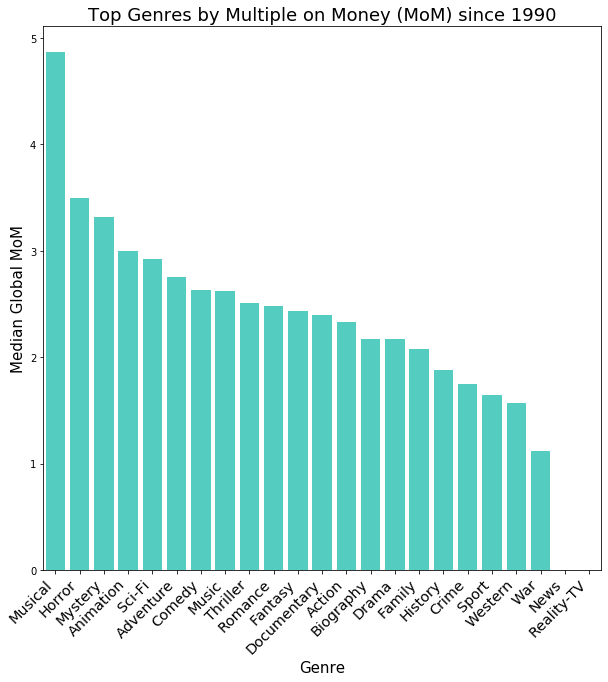

In [165]:
plt.figure(figsize=(10, 10))
chart = sns.barplot(x='genre',y='global_mom',data=genre_vs_mom_all, ci=None, color = 'turquoise')

# set labels
plt.xlabel("Genre", size=15)
plt.ylabel("Median Global MoM", size=15)
plt.title("Top Genres by Multiple on Money (MoM) since 1990", size=18)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

In [168]:
genre_vs_wwg_all = tbi_genre.groupby(['genre']).median().sort_values(by='worldwide_gross_$m',ascending=False)['worldwide_gross_$m']

In [172]:
genre_vs_wwg_all = genre_vs_wwg_all.reset_index()

,genre,worldwide_gross_$m
0,Animation,298.5
1,Sci-Fi,241.0
2,Musical,239.0
3,Adventure,227.0
4,Fantasy,130.0
5,Action,113.0
6,Family,101.0
7,Western,87.0
8,Comedy,66.0
9,Horror,54.0


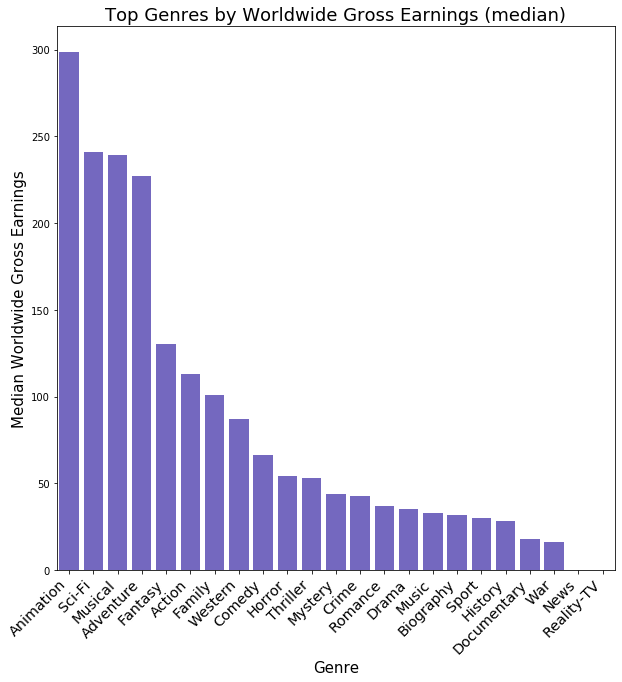

In [175]:
plt.figure(figsize=(10, 10))
chart = sns.barplot(x='genre',y='worldwide_gross_$m',data=genre_vs_wwg_all, ci=None, color = 'slateblue')

# set labels
plt.xlabel("Genre", size=15)
plt.ylabel("Median Worldwide Gross Earnings", size=15)
plt.title("Top Genres by Worldwide Gross Earnings (median)", size=18)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

In [198]:
mom_by_month = tbi.groupby(['release_month']).median().sort_values(by='release_month',ascending=True)['global_mom']

In [201]:
mom_by_month = mom_by_month.reset_index()

In [222]:
mom_by_month = mom_by_month.replace(to_replace = 12.0,value='December')
mom_by_month = mom_by_month.replace(to_replace = 11.0,value='November')
mom_by_month = mom_by_month.replace(to_replace = 10.0,value='October')
mom_by_month = mom_by_month.replace(to_replace = 9.0,value='September')
mom_by_month = mom_by_month.replace(to_replace = 8.0,value='August')
mom_by_month = mom_by_month.replace(to_replace = 7.0,value='July')
mom_by_month = mom_by_month.replace(to_replace = 6.0,value='June')
mom_by_month = mom_by_month.replace(to_replace = 5.0,value='May')
mom_by_month = mom_by_month.replace(to_replace = 4.0,value='April')
mom_by_month = mom_by_month.replace(to_replace = 3.0,value='March')
mom_by_month = mom_by_month.replace(to_replace = 2.0,value='February')
mom_by_month = mom_by_month.replace(to_replace = 11.0,value='January')


In [223]:
mom_by_month

,release_month,global_mom
0,January,1.600
1,February,1.770
2,March,1.675
3,April,1.470
4,May,2.200
5,June,2.260
6,July,2.430
7,August,1.720
8,September,1.340
9,October,1.510


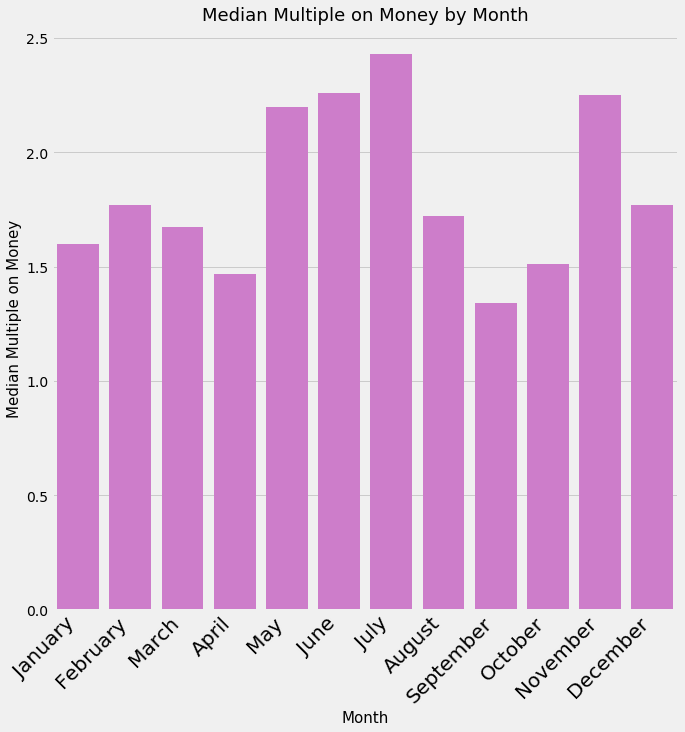

In [227]:

plt.figure(figsize=(10, 10))
chart = sns.barplot(x='release_month',y='global_mom',data=mom_by_month, color='orchid',ci=None)

# set labels
plt.xlabel("Month", size=15)
plt.ylabel("Median Multiple on Money", size=15)
plt.title("Median Multiple on Money by Month", size=18)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

### Notes

In [ ]:
# Use below three tables to do earnings / ROI by genre by season

In [ ]:
SELECT COUNT(*) 
FROM movies.imdb_title_basics
WHERE start_year > 2010
#total 146144 rows --> starts 2010 only 

In [ ]:
SELECT COUNT(*)
FROM movies.bom_movie_gross
# total 3387 rows --> total database only has 3387 rows and starts at 2010

In [ ]:
# tn movie budgets; bom movie gross; tmbd movies with unique titles 

In [ ]:
SELECT 
	COUNT(*),
    RIGHT(release_date, 4)
FROM movies.tn_movie_budgets
GROUP BY RIGHT(release_date, 4) ASC
#5782 rows total --> 1996 first year with over 100 movies 

SELECT 
	COUNT(*)
FROM movies.tn_movie_budgets
WHERE RIGHT(release_date, 4) > 1995
#4925
#2194 for 2010 and after

In [1]:
#GENERAL Analysis (JOIN ON Movie name)
#earnings / ROI by genre (tn_movie_budgets + imdb_title_basics JOIN on movie title) POST 2010 (only 2194 movies)
#earnings / ROI by season (use only tn_movie_budgets) POST 2010 (only 2194 movies)
#ratings vs. box office success correlatoin (movie_budgets and title_basics)
#IMDB analysis (JOIN ON nmstat and tstat)
#imdb genre vs. rating (use title_basics, title_ratings JOIN on tconst) POST 2010 (limit is ratings)
#imdb actors, directors and producers with highest ratings (use title_principals, title_ratings and 
#name_basics, JOIN on tconst and nmconst) POST 2010 (limit is ratings)
#RT Analysis (JOIN ON ID)
#overview of top critics, most frequent critics and what genres they like / how harsh they are (rt_reviews)
#rt ratings vs. box office reviews vs. top critics (1500 instances approx) limited by box office numbers in movie_info

In [ ]:
# LIST of databases
## DONT USE movies.bom_movie_gross for anything 
## DONT USE movies.imdb_name basics
## DONT USE imdb title akas
## DONT USE imdb title crew
## ONLY database with too many rows is imdb principles w/ over 1m 

In [ ]:
# TO DO
## Split genre into Primary, Secondary, Tertiary (for both ImDB and RT)